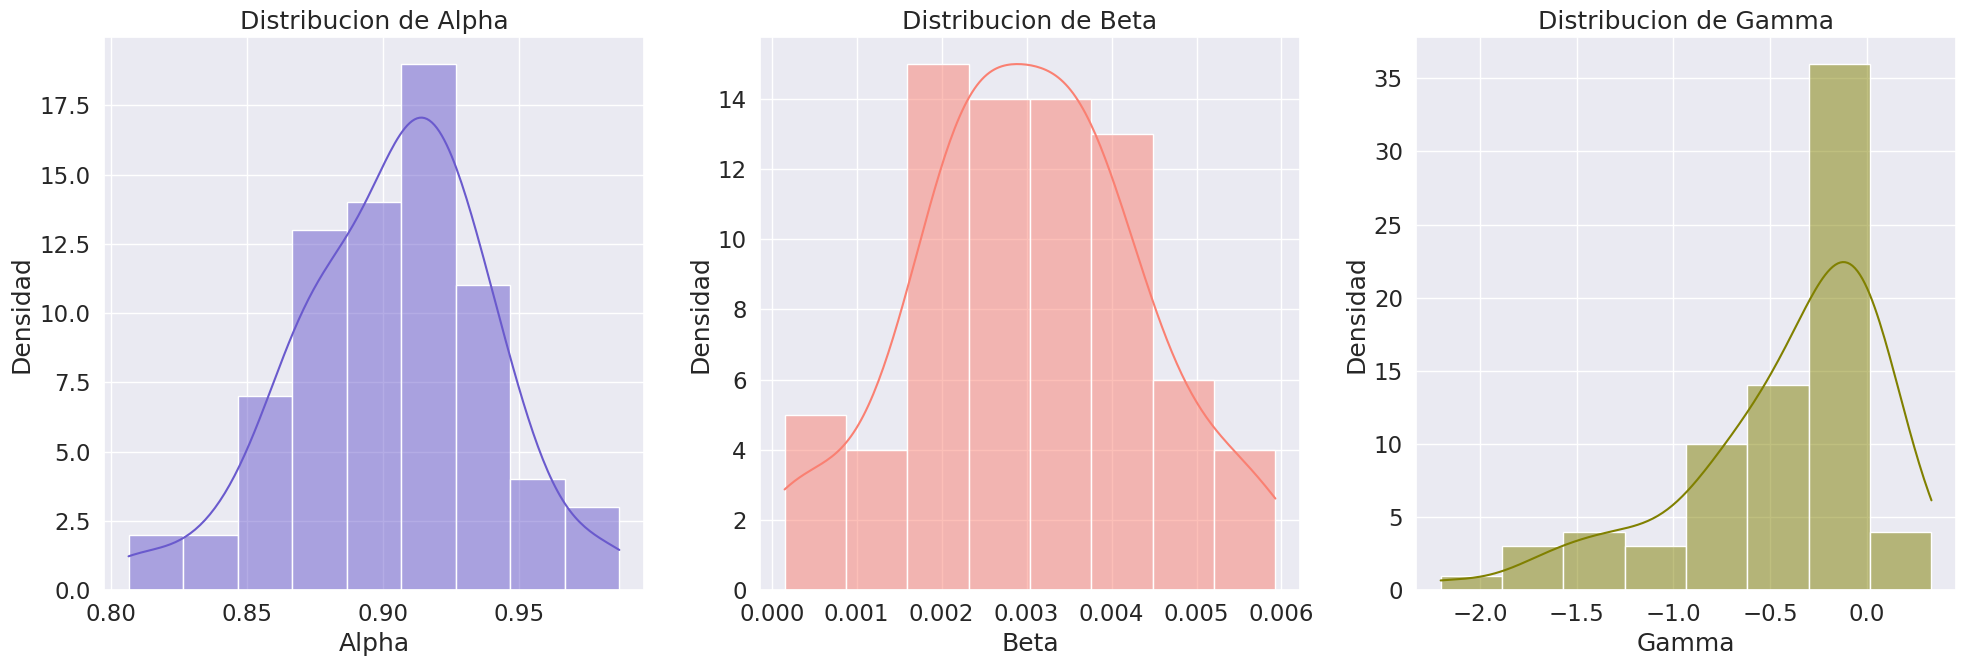

<ipython-input-8-e626072435c4>:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediccion_sum[j] += prediccion[j]


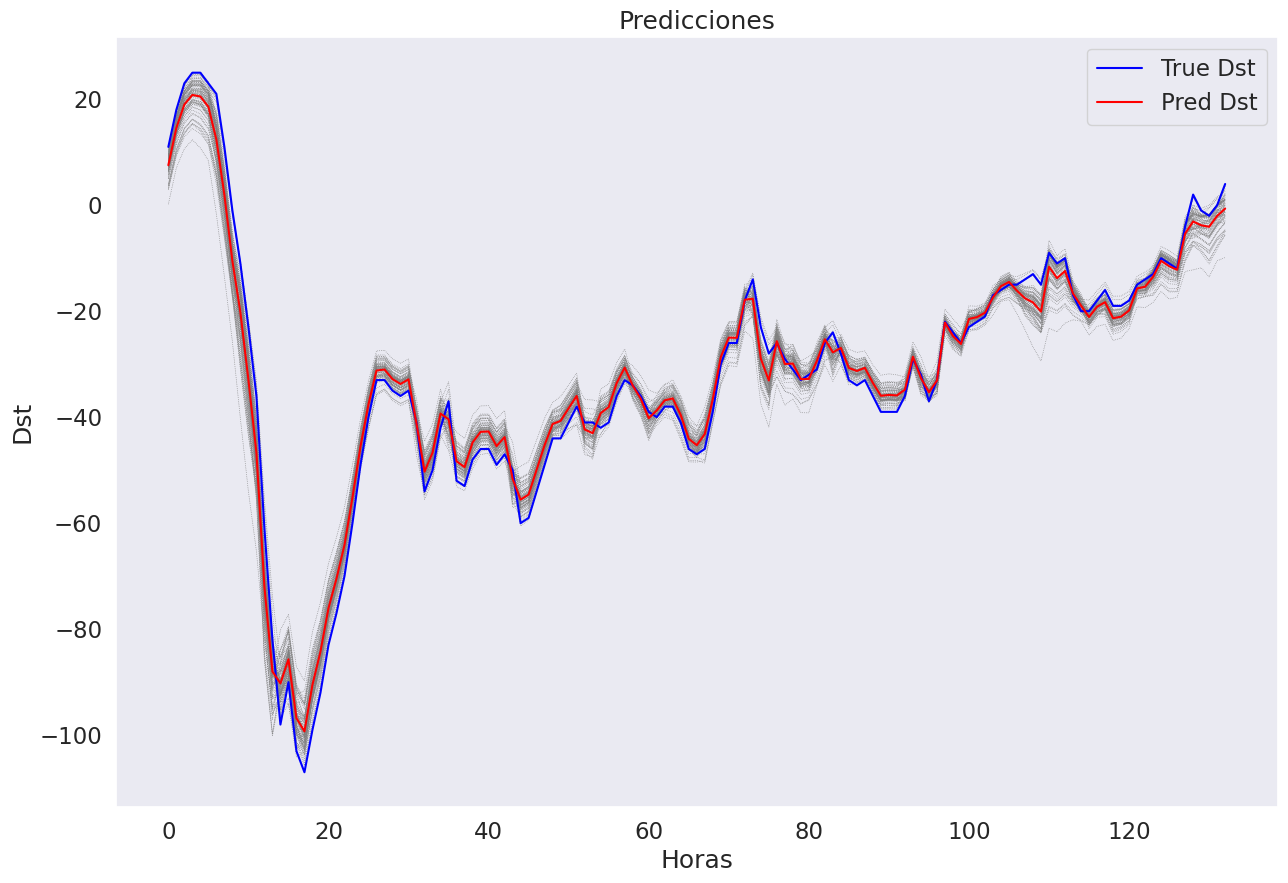

In [8]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_absolute_error as mae

# tormenta solar del 26 de marzo de 1995
# la tormenta solar del 26 de marzo de 1995 fue un evento significativo en la historia de la meteorologia espacial.
# durante esta tormenta, se observaron grandes perturbaciones en el campo magnetico terrestre y en la ionosfera.
# estas perturbaciones pueden afectar a los satelites, las comunicaciones por radio, las redes electricas y los sistemas de navegacion gps.
# el indice dst, que mide la intensidad de las tormentas geomagneticas, alcanzo un valor minimo de -107, indicando una tormenta moderada a severa.

t = timedelta(hours=1)  # buscar los datos con 1 hora de anticipacion

# carga de los datos
df = pd.read_csv("tormentas.txt", sep=",")  # fechas de las tormentas
data1 = pd.read_csv("omni.txt", sep=" ", index_col=False, parse_dates={'Date': ['dates', 'hour']}, dayfirst=True)  # todos los datos que necesito
data_in = df['date_in'].to_numpy()  # fechas de inicio de tormentas
data_out = df['date_out'].to_numpy()  # fechas de fin de tormentas

# convierte strings a datetime
data1["Date"] = pd.to_datetime(data1["Date"])

coeffs_list = []

# bucle sobre cada tormenta
for i in range(len(data_in)):
    in_date = datetime.strptime(data_in[i], '%Y-%m-%d %H:%M:%S')
    out_date = datetime.strptime(data_out[i], '%Y-%m-%d %H:%M:%S')
    # filtra datos dentro del rango de la tormenta
    mask = (data1['Date'] >= in_date) & (data1['Date'] < out_date)
    f_storm = data1.loc[mask]

    d_in = in_date + t
    d_out = out_date + t
    # filtra datos con 1 hora de anticipacion
    mask_u = (data1['Date'] >= d_in) & (data1['Date'] < d_out)
    storm = data1.loc[mask_u]

    # extraccion de datos relevantes
    aa = data1.loc[mask]
    bz = data1.loc[mask, 'bz']
    speed = data1.loc[mask, 'speed']
    pressure = data1.loc[mask, 'pressure']
    dst = data1.loc[mask, 'dst']
    dst_1 = data1.loc[mask_u, 'dst']  # una hora de anticipacion

    # calculo del campo electrico rectificado
    bbout = []
    for j in range(len(aa)):
        if bz.iloc[j] > 0:
            bbout.append(0)
        else:
            bbout.append(bz.iloc[j] * speed.iloc[j])

    # guardar datos como matrices / vectores
    X = np.vstack((dst_1))
    A = np.column_stack((dst, bbout, pressure))

    # calculo de coeficientes basado en metodo de minimos cuadrados
    AT = np.transpose(A)
    AA = np.mat(AT) * np.mat(A)
    IA = np.linalg.inv(np.mat(AA))
    B = np.mat(IA) * np.mat(AT)
    coeff = B * np.mat(X)

    coeffs_list.append(coeff.flatten().tolist()[0])  # guarda los coeficientes en la lista

# convertir lista de coeficientes en un array y guardarlo en un csv
coeffs_list = np.column_stack((data_in, data_out, coeffs_list))
df_coeffs = pd.DataFrame(coeffs_list, columns=['Fecha Inicio', 'Fecha Fin', 'alpha', 'beta', 'gamma'])
df_coeffs.to_csv('coefficients.csv', index=False)

# configuracion de graficos
size = 30
font_size = 20
col_list = ["Fecha Inicio", "Fecha Fin", "alpha", "beta", "gamma"]

# leer el archivo csv de coeficientes
data2 = pd.read_csv("coefficients.csv", usecols=col_list)
alfa = data2['alpha']
beta = data2['beta']
gamma = data2['gamma']

# configuracion de estilo de graficos
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 7))

# graficar distribuciones en linea
plt.subplot(1, 3, 1)
sns.histplot(alfa, kde=True, color='slateblue')
plt.title("Distribucion de Alpha")
plt.xlabel("Alpha")
plt.ylabel("Densidad")

plt.subplot(1, 3, 2)
sns.histplot(beta, kde=True, color='salmon')
plt.title("Distribucion de Beta")
plt.xlabel("Beta")
plt.ylabel("Densidad")

plt.subplot(1, 3, 3)
sns.histplot(gamma, kde=True, color='olive')
plt.title("Distribucion de Gamma")
plt.xlabel("Gamma")
plt.ylabel("Densidad")

plt.tight_layout()
plt.show()

# fechas de la tormenta solar del 26 de marzo de 1995
date_in = datetime(1995, 3, 26, 0, 0, 0)
date_out = datetime(1995, 3, 31, 13, 0, 0)
mask = (data1['Date'] >= date_in) & (data1['Date'] < date_out)

aa = data1.loc[mask]  # tiempo
bz = data1.loc[mask, 'bz']
speed = data1.loc[mask, 'speed']
pressure = data1.loc[mask, 'pressure']
dst = data1.loc[mask, 'dst']

# calculo campo electrico rectificado
bbout = []
for j in range(len(aa)):
    if bz.iloc[j] > 0:
        bbout.append(0)
    else:
        bbout.append(bz.iloc[j] * speed.iloc[j])

A = np.column_stack((dst, bbout, pressure))

prediccion_list = []
prediccion_sum = np.zeros(len(aa))

# bucle sobre cada coeficiente calculado
for i in range(len(data2)):
    Alpha = data2['alpha'][i]
    Beta = data2['beta'][i]
    Gamma = data2['gamma'][i]

    coeff = np.vstack((Alpha, Beta, Gamma))
    prediccion = np.mat(A) * coeff

    # se elimina de estimacion de promedio la tormenta en estudio.
    if date_in != datetime.strptime(data2['Fecha Inicio'][i], '%Y-%m-%d %H:%M:%S'):
        for j in range(len(prediccion)):
            prediccion_sum[j] += prediccion[j]

    prediccion_list.append(prediccion.flatten().tolist()[0])

prediccion_med = prediccion_sum / (len(data2) - 1)  # calculo de promedio.

# construccion de grafico
plt.figure(figsize=(15, 10))
plt.title('Predicciones')
plt.xlabel('Horas')
plt.ylabel('Dst')

plt.grid(False)

# graficar cada prediccion individual
for i in range(len(prediccion_list)):
    t = np.array(range(len(prediccion_list[i])))
    plt.plot(t, prediccion_list[i], color='grey', linewidth=0.5, linestyle=':')

# graficar el valor real y el promedio de las predicciones
ti = np.array(range(len(aa)))
plt.plot(ti, dst, color='blue', label='True Dst')

tm = np.array(range(len(prediccion_med)))
plt.plot(tm, prediccion_med, color='red', label='Pred Dst')

plt.legend()
plt.show()



